In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from project_code.preprocessor import split_data
import pickle

In [71]:

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

2024-07-04 15:10:29.706619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### importing and loading data

In [4]:
%cd ..

/Users/Marie/code/MarieMCodes/re_value_predictor


/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [64]:
data=pd.read_csv('raw_data/london_re_postcodes_latlon_master.zip',
                    dtype={'price': np.int32,'month':np.int8,'year':np.int16},
                    ).sample(300000)
    # master: drop month, drop date
data.drop(columns=['date','month'],inplace=True)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 408495 to 1061438
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          100000 non-null  int32  
 1   property_type  100000 non-null  object 
 2   property_age   100000 non-null  object 
 3   ownership      100000 non-null  object 
 4   year           100000 non-null  int16  
 5   lat            100000 non-null  float64
 6   lon            100000 non-null  float64
 7   sin_time       100000 non-null  float64
 8   cos_time       100000 non-null  float64
dtypes: float64(4), int16(1), int32(1), object(3)
memory usage: 6.7+ MB


In [95]:
X=data.drop(columns='price')
y=data[['price']]
y.shape

(300000, 1)

In [110]:
# exploring prices and outliers in recent years
data[data['year']>2020].describe()

,price,year,lat,lon,sin_time,cos_time
count,3.165900e+04,31659.000000,31659.000000,31659.000000,3.165900e+04,3.165900e+04
mean,6.916474e+05,2021.509492,51.498837,-0.115222,1.034899e-01,-6.448691e-02
std,6.851404e+05,0.606207,0.077155,0.153160,7.077638e-01,6.958684e-01
min,2.000000e+05,2021.000000,51.293401,-0.498166,-1.000000e+00,-1.000000e+00
25%,3.850000e+05,2021.000000,51.443223,-0.210711,-5.000000e-01,-8.660254e-01
50%,5.157610e+05,2021.000000,51.499752,-0.116026,1.224647e-16,-1.836970e-16
75%,7.400000e+05,2022.000000,51.559608,-0.015721,8.660254e-01,5.000000e-01
max,1.400000e+07,2023.000000,51.682136,0.325661,1.000000e+00,1.000000e+00


In [111]:
data[(data['year']>2020) & (data['price']>10000000)]

,price,property_type,property_age,ownership,year,lat,lon,sin_time,cos_time
1959092,11750000,T,N,F,2022,51.513074,-0.205475,1.000000e+00,6.123234e-17
1892059,12790000,T,N,F,2021,51.488992,-0.172297,-5.000000e-01,-8.660254e-01
1812442,10900000,F,Y,L,2021,51.489060,-0.154163,1.000000e+00,6.123234e-17
1968644,12600000,T,N,F,2022,51.494534,-0.150091,1.000000e+00,6.123234e-17
1894618,10187500,F,Y,L,2021,51.516404,-0.145980,5.000000e-01,8.660254e-01
1848052,11030000,T,N,L,2021,51.520319,-0.144650,1.224647e-16,-1.000000e+00
1809551,12500000,T,N,F,2021,51.498175,-0.185703,1.224647e-16,-1.000000e+00
1990182,12500000,F,N,L,2023,51.501396,-0.163876,8.660254e-01,-5.000000e-01
1969154,11750000,T,N,F,2022,51.491642,-0.188324,-1.000000e+00,-1.836970e-16
1892258,12621255,F,Y,L,2021,51.516404,-0.145980,1.000000e+00,6.123234e-17


In [113]:
data['property_type'].unique()

array(['F', 'T', 'S', 'D'], dtype=object)

### Preprocessing data

In [96]:
def preprocess_X(X):
    preprocessor=pickle.load(open("models/preprocessor_latlon.pkl","rb"))
    X_processed=preprocessor.transform(X)
    print(f"✅ new data processed with shape {X_processed.shape}")
    return X_processed

def process_y(y):
    y_processed=np.log(y)
    print(f"✅ y logged  with shape {y_processed.shape}")
    return y_processed


def split_x_y(X_processed,y_processed):
    # split the processed X and y
    X_train, X_test, y_train, y_test= split_data(X_processed,y_processed)
    return X_train, X_test, y_train, y_test


def process_and_split(X,y):
    X_processed=preprocess_X(X)
    y_processed=process_y(y)
    X_train, X_test, y_train, y_test=split_x_y(X_processed,y_processed)
    return X_train, X_test, y_train, y_test


In [62]:
!pwd

/Users/Marie/code/MarieMCodes/re_value_predictor


In [97]:
X_train, X_test, y_train, y_test=process_and_split(X,y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

✅ new data processed with shape (300000, 11)
✅ y logged  with shape (300000, 1)


((210000, 11), (90000, 11), (210000, 1), (90000, 1))

### Building model architecture -> into Pipeline

In [101]:
def initialize_model() -> Model:
    """
    Initialize the Neural Network with random weights
    """
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))  # Output layer
    return model


def compile_model(model:Model, learning_rate: 0.001, epochs: 50, batch_size=32) -> tuple[Model, dict]:
    """
    compiles model
    """
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    print("✅ Model compiled")
    return model


def train_model(
        model: Model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        batch_size=64,
        patience=2,
        validation_data=None,
        validation_split=0.3
    ) -> tuple[Model, dict]:
    """
    trains model
    """
    print("starting model training")

    es = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        validation_split=validation_split,
        epochs=100,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    print(f"✅ Model trained on {len(X_train)} rows with min val MAE: {round(np.min(history.history['val_mae']), 2)}")

    return model, history




def evaluate_model(model: Model, X_test: np.ndarray, y_test: np.ndarray) -> tuple[float, float]:
    """
    evaluate trained model on test data
    """
    metrics = model.evaluate(X_test,
                             y_test,
                             batch_size=32,
                             return_dict=True
    )

    mse = metrics["loss"]
    mae = metrics["mae"]
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    return mae, mse


### Run model

In [103]:
# initialise_model
model=initialize_model()

# compile_model
model=compile_model(model,learning_rate=0.001, epochs=80 )

# train_model
model,history=train_model(model,X_train,y_train)
print('✅ model finished training')

#save model
#save_model(model, '../models/model_latlon_full.h5')
#print('✅ model saved ')

# evaluate
mae, mse=evaluate_model(model,X_test,y_test)
print(f'MAE is {mae}, and MSE is {mse}. Training is complete')

✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 11.
Epoch 13: early stopping
✅ Model trained on 210000 rows with min val MAE: 0.27
✅ model finished training
2813/2813 [==============================] - 6s 2ms/step - loss: 0.1398 - mae: 0.2683
Mean Absolute Error (MAE): 0.26827889680862427
Mean Squared Error (MSE): 0.1398274451494217
MAE is 0.26827889680862427, and MSE is 0.1398274451494217. Training is complete


### Plot learning history of model

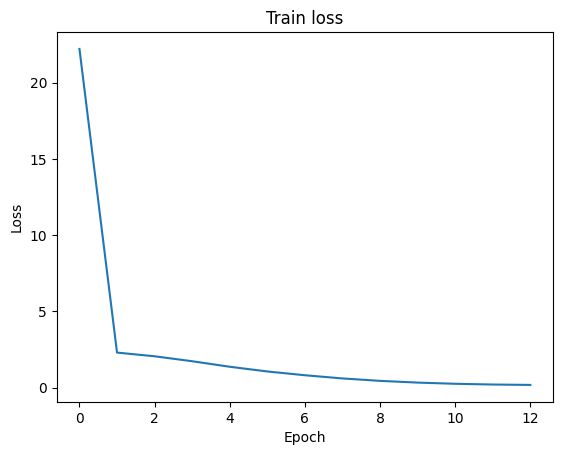

In [104]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)

### Predict against X_test

In [105]:
def prediction(X_new):
    
    # year=2023,
    # property_type='F',
    # property_age='O',
    # ownership='L',
    # lat=51.491539,
    # lon=0.026218,
    # sin_time=0.5,
    # cos_time=0.85)
    """
    takes new X, processes them and predicts
    """
    #y_new=pd.DataFrame(locals(),index=[0])
    #print(f"✅ new data loaded in df with shape {X_new.shape}")

    # load preprocessor
    # preprocessor=pickle.load(open("models/preprocessor_latlon.pkl","rb"))
    # X_new_processed=preprocessor.transform(X_new)
    # print(f"✅ new data processed with shape {X_new_processed.shape}")

    # predict
    X_new_processed=X_new
    ypred=model.predict(X_new_processed)
    print("✅ model predicted")

    # reverse log price to actual price
    prediction=np.exp(ypred)
    print(f" Your predicted price for the property is: {prediction}")
    return prediction

prediction=prediction(X_test)

2813/2813 [==============================] - 5s 2ms/step
✅ model predicted
 Your predicted price for the property is: [[253354.25]
 [275580.78]
 [665544.94]
 ...
 [451726.84]
 [325289.4 ]
 [508163.9 ]]


### Plot predictions (of x-test) against actual y-test

In [106]:
y_test_exp=np.exp(y_test)
y_test_exp

,price
2122632,260000.0
365539,244950.0
395810,2450000.0
687916,345000.0
98696,540000.0
...,...
1072874,485000.0
1753522,780000.0
1741484,379500.0
2138048,315000.0


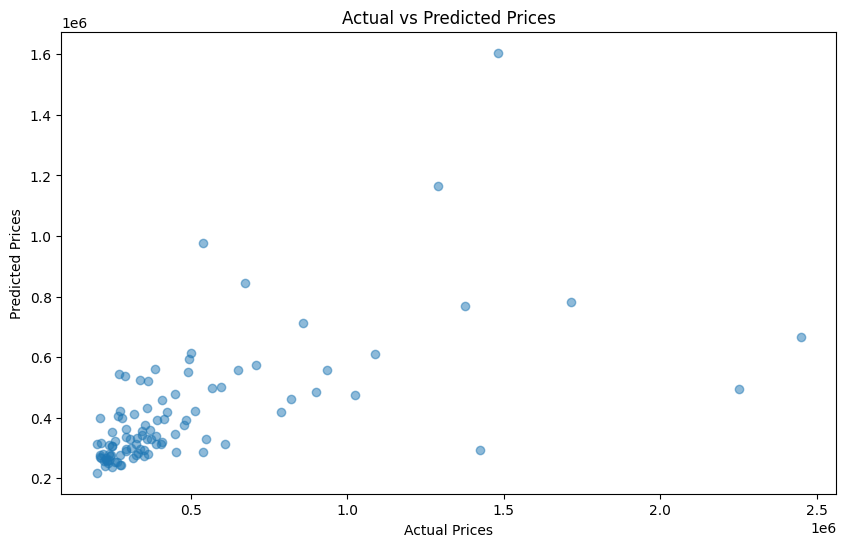

In [109]:

def plot_predictions(y_test: np.ndarray, y_pred: np.ndarray):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Prices')
    #plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

plot_predictions(y_test_exp[:100],prediction[:100])

In [ ]:
results_train = model.evaluate(X_train, y_train, verbose = 0)
results_test = model.evaluate(X_test, y_test, verbose = 0)

loss_train=results_train[0]
loss_test=results_test[0]
print (f"loss from training is {loss_train} vs loss from test data {loss_test}")
print(" if train score is > test score, then model is overfitting. Underfitting if ")